# TopoCluster Regression: IQR Comparison

#### 1) Initial setup

In [1]:
# Import some basic libraries.
import sys, os, uuid, glob, pickle, pathlib
import numpy as np
import pandas as pd # we will use some uproot/pandas interplay here.
import uproot as ur
import ROOT as rt # used for plotting
import joblib as jl # for saving scalers
from numba import jit
    
# Import our resolution utilities
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util       as pu
from util import ml_util         as mu
from util import qol_util        as qu
from util import io_util         as iu

rt.gStyle.SetOptStat(0)
# use our custom dark style for plots
plotstyle = qu.PlotStyle('dark')
plotstyle.SetStyle() # still need to manually adjust legends, paves

plotpath = path_prefix + 'regression/Plots/'
modelpath = path_prefix + 'regression/Models/'
paths = [plotpath, modelpath]
for path in paths:
    try: os.makedirs(plotpath)
    except: pass

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.22/02


#### 2) Get the data.

Let me lay out some definitions, so it's clear as to what the data is.

We have a number of different "strategies" (the `strat` variable at the top). These correspond to different choices of training, validation and testing datasets.

1. `pion`: We train and validate the network using our pion gun data.

2. `pion_reweighted`: This is the same as `pion`, except that our training data is reweighted using a jet dataset (via their reco topo-cluster $p_T$ distributions), that corresponds with QCD dijet events.

3. `jet`: We train and validate the network using our jet data. This is a facsimile dataset -- we do not know the actual labels of the jet data topo-clusters, so we have assigned labels by matching clusters to truth-level pions in $(\eta,\phi)$.

The validation performed for these networks is effectively being done on some "holdout" dataset from training -- it will by definition have similar kinematics, being drawn from the same set of events. The more interesting test -- how our energy regression performs in tandem with classification on our *unlabeled* jet dataset, will be handled in a separate notebook.

In [2]:
strat = 'pion'
data_dir = path_prefix + 'data/pion/'
data_filenames = {'pp':data_dir+'piplus.root','pm':data_dir+'piminus.root','p0':data_dir+'pi0.root'}
    
#adjust our model and plot paths, so that they are unique for each strategy
paths = [modelpath, plotpath]
for i in range(len(paths)):
    path = paths[i]
    path = path + strat
    try: os.makedirs(path)
    except: pass
    path = path + '/'
    paths[i] = path
modelpath, plotpath = paths

# we get uproot trees and pandas DataFrames,
# for training + validation
tree_name = 'ClusterTree'
branches = ['truthE', 'clusterE', 'clusterPt', 'clusterEta', 'cluster_ENG_CALIB_TOT']

data_trees = {key:ur.open(val)[tree_name] for key,val in data_filenames.items()}
data_frames = {key:val.pandas.df(branches,flatten=False) for key,val in data_trees.items()}

#### Preparing training, validation and testing samples

Here, we're going to arrange our dataset into training, validation and testing samples (by defining the indices of these categories).


As we're taking logarithms  of `clusterE` and `cluster_ENG_CALIB_TOT`, we will always perform cuts to have `clusterE` > 0 for all datasets, and `cluster_ENG_CALIB_TOT` > 0 for training. 

On top of those cuts, we're free to apply additional cuts to training, validation and testing data. We can do them below, as we pick event indices for each dataset.

Since we treat $\pi^+$ and $\pi^-$ as the same, let's combine them so that we have *charged* and *neutral* pions. We will store all the charged pions under the key `pp`, and delete the key `pm`.

In [3]:
key_conversion = {'pp':'charged pion','p0':'neutral pion'}
# combining dataframes
if('pm' in data_frames.keys()):
    data_frames['pp'] = data_frames['pp'].append(data_frames['pm'])
    del data_frames['pm']
    
    data_trees['pp'] = [data_trees['pp'],data_trees['pm']]
    data_trees['p0'] = [data_trees['p0']]
    del data_trees['pm']

In [4]:
training_frames = {}
validation_frames = {}

# First, the minimum energy cut that we will always apply to data. Anything that fails to pass this cut will be discarded,
# we will never evaluate on events that don't pass this cut.
global_energy_cut = 0.

# We apply a lower cut on cluster_ENG_CALIB_TOT, as very low-energy clusters can throw off training.
energy_cut = [0., -1.]
if(strat == 'pion' or strat == 'pion_reweighted'): 
    energy_cut[0] = 0. # GeV (e.g. 5.0e-1 by default)
    energy_cut[1] = -1.
    
elif(strat == 'jet'): 
    energy_cut[0] = 5.0e-2 # GeV
    energy_cut[1] = -1.

data_indices = {} # indices of all usable data, i.e. non-zero energy
training_indices = {} # indices of events actually used for training
validation_indices = {} # indices of events not used for training (but usable)

# percent of events to hand over from training to testing
testing_frac = 0.2
rng = np.random.default_rng() # for shuffling indices when splitting training/testing
for key in data_frames.keys():
    n = len(data_frames[key])
    eng_calib_tot = data_frames[key]['cluster_ENG_CALIB_TOT'].to_numpy()
    selected_indices = eng_calib_tot > energy_cut[0]
    if(energy_cut[1] > 0.): selected_indices = selected_indices * (eng_calib_tot < energy_cut[1])
    
    selected_indices = selected_indices.nonzero()[0] # from boolean array to a list of actual indices
    rng.shuffle(selected_indices)
    n_test = int(testing_frac * len(selected_indices))
    
    # making boolean arrays to select events -- arrays are of same length as dataframe
    validation_indices[key] = np.full(n,False)
    training_indices[key] = np.full(n,False)
    validation_indices[key][np.sort(selected_indices[:n_test])] = True
    training_indices[key][np.sort(selected_indices[n_test:])] = True

    data_indices[key] = (data_frames[key]['cluster_ENG_CALIB_TOT'] > global_energy_cut).to_numpy()
    data_frames[key] = data_frames[key][data_indices[key]]

In [5]:
for key in data_frames.keys():
    print('Number of {type} training/testing events: {val1}/{val2}'.format(type=key_conversion[key], val1 = np.sum(training_indices[key]), val2 = np.sum(validation_indices[key])))

Number of charged pion training/testing events: 699001/174750
Number of neutral pion training/testing events: 211334/52833


Note that we have many more charged pions than neutral pions, so this *may* result in our charged pion regression being better-trained (unless the stats for both are sufficiently high).

### Defining regression variables & Loading models

Beyond the information already present in the data, we may want to pre-compute some extra regression inputs.

The different models we're comparing may require different regression variables.

In [6]:
#cases = ['caseA','caseB','caseC','caseD']
#cases = ['caseD','caseD2']
#cases = ['resnet','caseD']
cases = ['all','simple']
suffixes = {'pp':'charged','p0':'neutral'}

# Set up the appropriate energy mappings.
EnergyMapping = {
    'caseA':iu.SimpleLogMapping(),
    'caseB':iu.LogMapping(b=1.0e3),
    'caseC':iu.LogMapping(b=1.),
    'caseD':iu.LinLogMapping(b=1.,m=1.),
    'caseD2':iu.LinLogMapping(b=1.,m=1.),
    'resnet':iu.LinLogMapping(b=1.,m=1.),
    'resnet_mini':iu.LinLogMapping(b=1.,m=1.),
    'all':iu.LinLogMapping(b=1.,m=1.),
    'simple':iu.LinLogMapping(b=1.,m=1.)
}

# Get the the appropriate model keys (these can be identical for models -- they are based on architecture).
model_keys = {
    'caseA':'all',
    'caseB':'all',
    'caseC':'all',
    'caseD':'all',
    'caseD2':'all',
    'resnet':'resnet',
    'resnet_mini':'resnet_mini',
    'all':'all',
    'simple':'simple'
}

# Fetch the model and history files.
model_files = {
    key:{
        key2:'{}{}/{}_{}.h5'.format(modelpath,key,model_keys[key],suffix)
        for key2,suffix in suffixes.items()
    }
    for key in cases
}
history_files = {
    key:{
        key2:'{}{}/{}_{}.history'.format(modelpath,key,model_keys[key],suffix)
        for key2,suffix in suffixes.items()
    }
    for key in cases
}

# Fetch the scaler files
scaler_files = {
    key:'{}{}/scalers.save'.format(modelpath,key)
    for key in cases
}

In [7]:
# Now we get our regression variables, one set for each case, and fit/apply scalers.
from sklearn.preprocessing import StandardScaler

scaler_cal = {} # need to save these for later

for key,frame in data_frames.items():
    for case in cases:
        print(case,key)
        frame['logE_{}'.format(case)] = EnergyMapping[case].Forward(frame['clusterE'].to_numpy())
        frame['logECalib_{}'.format(case)] = EnergyMapping[case].Forward(frame['cluster_ENG_CALIB_TOT'].to_numpy())
        
        # Now fit and apply scalers.
        scalers = jl.load(scaler_files[case])
        scaler_e, scaler_cal[case], scaler_eta = scalers['e'], scalers['cal'], scalers['eta']
        
        scaler_e[key].fit(frame['logE_{}'.format(case)][training_indices[key]].to_numpy().reshape(-1,1))
        scaler_cal[case][key].fit(frame['logECalib_{}'.format(case)][training_indices[key]].to_numpy().reshape(-1,1))
        scaler_eta[key].fit(frame['clusterEta'][training_indices[key]].to_numpy().reshape(-1,1))
        
        frame['s_logE_{}'.format(case)] = scaler_e[key].transform(frame['logE_{}'.format(case)].to_numpy().reshape(-1,1))
        frame['s_logECalib_{}'.format(case)] = scaler_cal[case][key].transform(frame['logECalib_{}'.format(case)].to_numpy().reshape(-1,1))
        frame['s_eta'] = scaler_eta[key].transform(frame['clusterEta'].to_numpy().reshape(-1,1))

all pp
simple pp
all p0
simple p0


In [8]:
sample_weights = {key:np.full(int(np.sum(training_indices[key])), 1.) for key in training_indices.keys()}

## Tensorflow/Keras Prep

In this workflow we have the ability to train a number of models -- some will require additional data setup. Here, we have some basic setup they will all use.

In [9]:
models = {} # keep track of the models -- note that we train multiple instances of each model
histories = {} # keep track of histories of the models we train
regressors = {} # keep track of the trained models (will be KerasRegressor objects)
energy_names = {} # keep track of the names of regressed variables

energy_name_prefix = 'clusterE_pred'

In [10]:
from keras.wrappers.scikit_learn import KerasRegressor # scikit_learn wrapper -- why do we use this, vs. native tf.keras approach like in classification notebook?
from tensorflow.keras.models import load_model

In [11]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable some of the tensorflow info printouts, only display errors
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [12]:
from models import baseline_nn_All_model, resnet
import training_utils as tu

In [14]:
# Not sure if this stuff is needed, but these hyper-params match for all models of same architecture
lr = 1e-4
decay = 1e-6
dropout = -1. # < 0 -> no dropout
batch_size = 200 * ngpu
epochs = 20 # 20
verbose = 1
model = baseline_nn_All_model(strategy, lr=lr, decay=decay, dropout=dropout)
calo_images = tu.LoadCaloImages(data_trees,data_indices,layers)
for case in cases:
    print(case)
    regressors = {key: KerasRegressor(build_fn=model, batch_size=batch_size, epochs=epochs, verbose=verbose) for key in training_indices.keys()}
    
    if(model_keys[case] == 'all'):
        All_input = tu.CombinedInput(data_frames, data_trees, data_indices, input_keys = ['s_logE_{}'.format(case),'s_eta'],calo_images=calo_images)
        train_input = {key:All_input[key][training_indices[key]] for key in All_input.keys()}
        valid_input = {key:All_input[key][validation_indices[key]] for key in All_input.keys()}

    else:
        if(model_keys[case] in ['resnet','resnet_mini']):
            All_input = tu.ResnetInput(data_frames, data_trees, data_indices, layers, cell_shapes, input_keys = ['s_logE_{}'.format(case),'s_eta'], calo_images=calo_images)
        else: 
            All_input = tu.DepthInput(data_frames, data_trees, data_indices, layers, input_keys = ['s_logE_{}'.format(case),'s_eta'], calo_images=calo_images)
        Split_input = tu.DictionarySplit(All_input, training_indices, validation_indices)
        train_input = Split_input['train']
        valid_input = Split_input['valid']

        if('mini' in case):
            mini_keys = ['input0','energy','eta']
            mini_input = {
                key:{mkey:val[mkey] for mkey in mini_keys}
                for key,val in All_input.items()
            }
            mini_train = {
                key:{mkey:val[mkey] for mkey in mini_keys}
                for key,val in train_input.items()
            }
            mini_valid = {
                key:{mkey:val[mkey] for mkey in mini_keys}
                for key,val in valid_input.items()
            }
            train_input = mini_train
            valid_input = mini_valid
            
    for key in All_input.keys():
        tidx = training_indices[key]
        vidx = validation_indices[key]
        loadModel = True
        saveModel = False
        
        modelfile = model_files[case][key] # will override the modelpath/suffix/model_key arguments TODO: make this cleaner
        history = tu.PrepNetwork(
            regressor=regressors[key],
            model_key='all', # not used!
            suffix='_' + suffixes[key], # not used!
            modelpath=modelpath, # not used!
            modelfile=modelfile,
            loadModel=loadModel,
            x_train = train_input[key],
            y_train = data_frames[key]['s_logECalib_{}'.format(case)][tidx],
            x_valid = valid_input[key],
            y_valid = data_frames[key]['s_logECalib_{}'.format(case)][vidx],
            sample_weight=sample_weights[key],
            saveModel=saveModel
        )
        energy_names[case] = '{}_{}'.format(energy_name_prefix,case)
        data_frames[key][energy_names[case]] = EnergyMapping[case].Inverse(scaler_cal[case][key].inverse_transform(regressors[key].predict(All_input[key])))

Loading calo images:       |██████████████████████████████████████████████████| 100.0% Complete
all
Preparing combined input:  |██████████████████████████████████████████████████| 100.0% Complete
     Loading model at /local/home/jano/ml4pions/LCStudies/regression/../regression/Models/pion/all/all_charged.h5.
   Loading history at /local/home/jano/ml4pions/LCStudies/regression/../regression/Models/pion/all/all_charged.history.
4369/4369 [==============================] - 9s 2ms/step
     Loading model at /local/home/jano/ml4pions/LCStudies/regression/../regression/Models/pion/all/all_neutral.h5.
   Loading history at /local/home/jano/ml4pions/LCStudies/regression/../regression/Models/pion/all/all_neutral.history.
1321/1321 [==============================] - 3s 2ms/step
simple
     Loading model at /local/home/jano/ml4pions/LCStudies/regression/../regression/Models/pion/simple/simple_charged.h5.
   Loading history at /local/home/jano/ml4pions/LCStudies/regression/../regression/Models/pi

## Plotting IQR

Now let's plot the IQR for all of the methods, for $E_\text{pred}/E_\text{true}$ versus $E_\text{true}$. We'll include the IQR from using the reco energy `clusterE`, since this is a decent benchmark that we'd like to beat.

In [15]:
# for convenience below
training_frames = {key:frame[training_indices[key]] for key,frame in data_frames.items()}
validation_frames = {key:frame[validation_indices[key]] for key,frame in data_frames.items()}

In [16]:
from plotting_utils import IqrPlot, MedianPlot
colors = {
    'caseA': rt.kRed,
    'caseB': rt.kOrange,
    'caseC': rt.kGreen,
    'caseD': rt.kViolet,
    'reco' : plotstyle.curve,
    'caseD2': rt.kPink,
    'resnet': rt.kRed,
    'resnet_mini': rt.kGreen,
    'all': rt.kRed,
    'simple':rt.kCyan
}

max_energy = 2000. # GeV

In [17]:
cases_extended = cases + ['reco']
energy_names['reco'] = 'clusterE'

median = {}
median_zoomed = {}
iqr = {}
iqr_zoomed = {}
for key,frame in data_frames.items():
    
    print(key)
    
    median[key] = {}
    median_zoomed[key] = {}
    iqr[key] = {}
    iqr_zoomed[key] = {}
    
    for case in cases_extended:
        print('\t',case)
        
        median[key][case]        = MedianPlot(frame[energy_names[case]].to_numpy(), frame['cluster_ENG_CALIB_TOT'].to_numpy(), title=case, nbins=100, x_range=[0.,max_energy])
        median_zoomed[key][case] = MedianPlot(frame[energy_names[case]].to_numpy(), frame['cluster_ENG_CALIB_TOT'].to_numpy(), title=case, nbins=199, x_range=[1.,1. + 0.01 * max_energy], offset=True)
        
        iqr[key][case]        = IqrPlot(frame[energy_names[case]].to_numpy(), frame['cluster_ENG_CALIB_TOT'].to_numpy(), title=case, nbins=100, x_range=[0.,max_energy])
        iqr_zoomed[key][case] = IqrPlot(frame[energy_names[case]].to_numpy(), frame['cluster_ENG_CALIB_TOT'].to_numpy(), title=case, nbins=199, x_range=[1.,1. + 0.01 * max_energy], offset=True)

        for p in [iqr[key][case],iqr_zoomed[key][case],median[key][case],median_zoomed[key][case]]:
            p.SetLineColor(colors[case])
            p.SetLineWidth(2)

pp
	 all


/local/home/jano/miniconda3/envs/ml4p/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/jano/miniconda3/envs/ml4p/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	 simple
	 reco
p0
	 all
	 simple
	 reco


In [18]:
# Make a legend.
y2 = 0.9
y1 = y2 - len(cases_extended) * 0.2 / 4
legend = rt.TLegend(0.7,y1,0.9,y2)
for key,hist in iqr['pp'].items():
    legend.AddEntry(hist,key,'l')
legend.SetTextColor(plotstyle.text)

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/regression/../regression/Plots/pion/iqr_pp.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/regression/../regression/Plots/pion/iqr_zoomed_pp.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/regression/../regression/Plots/pion/iqr_p0.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/regression/../regression/Plots/pion/iqr_zoomed_p0.png has been created


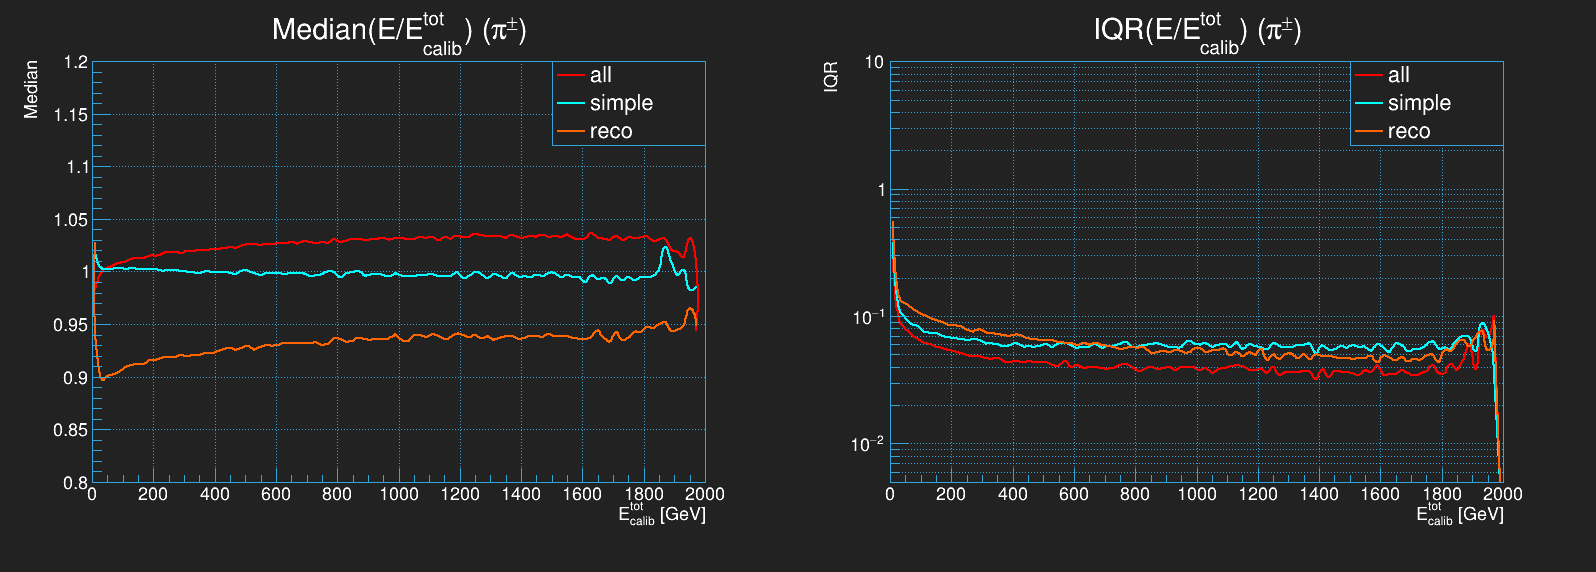

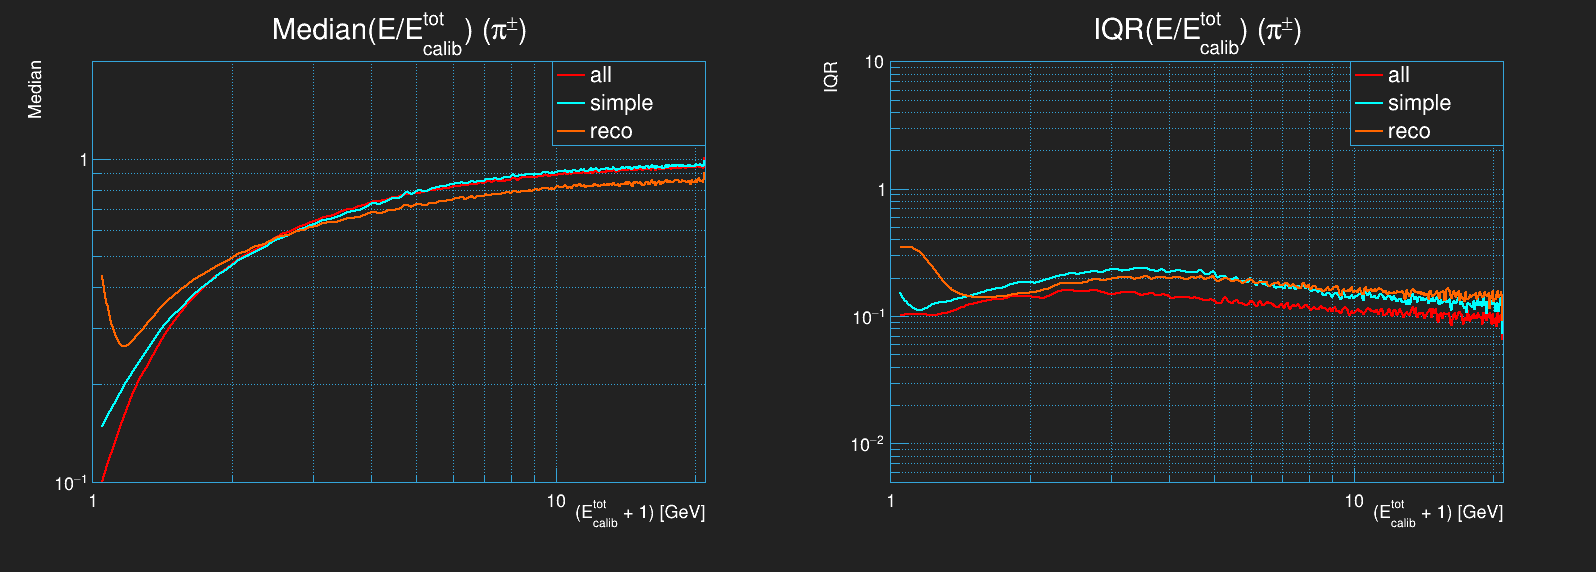

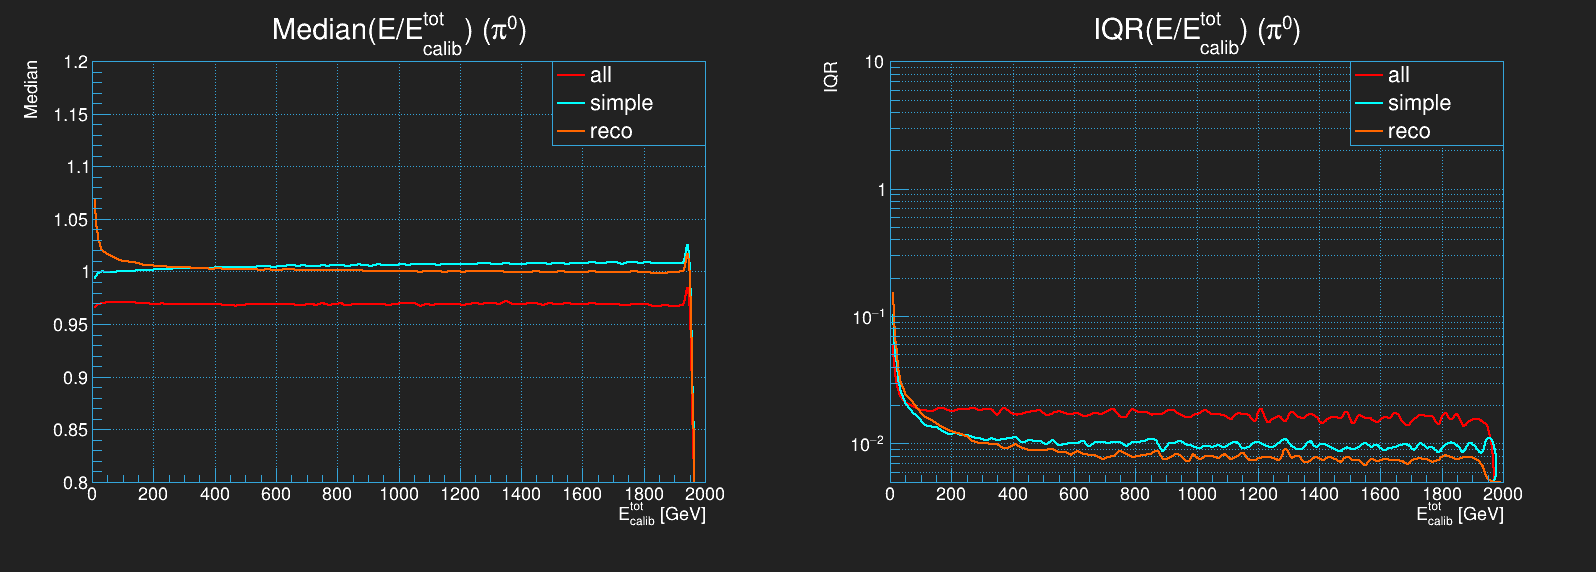

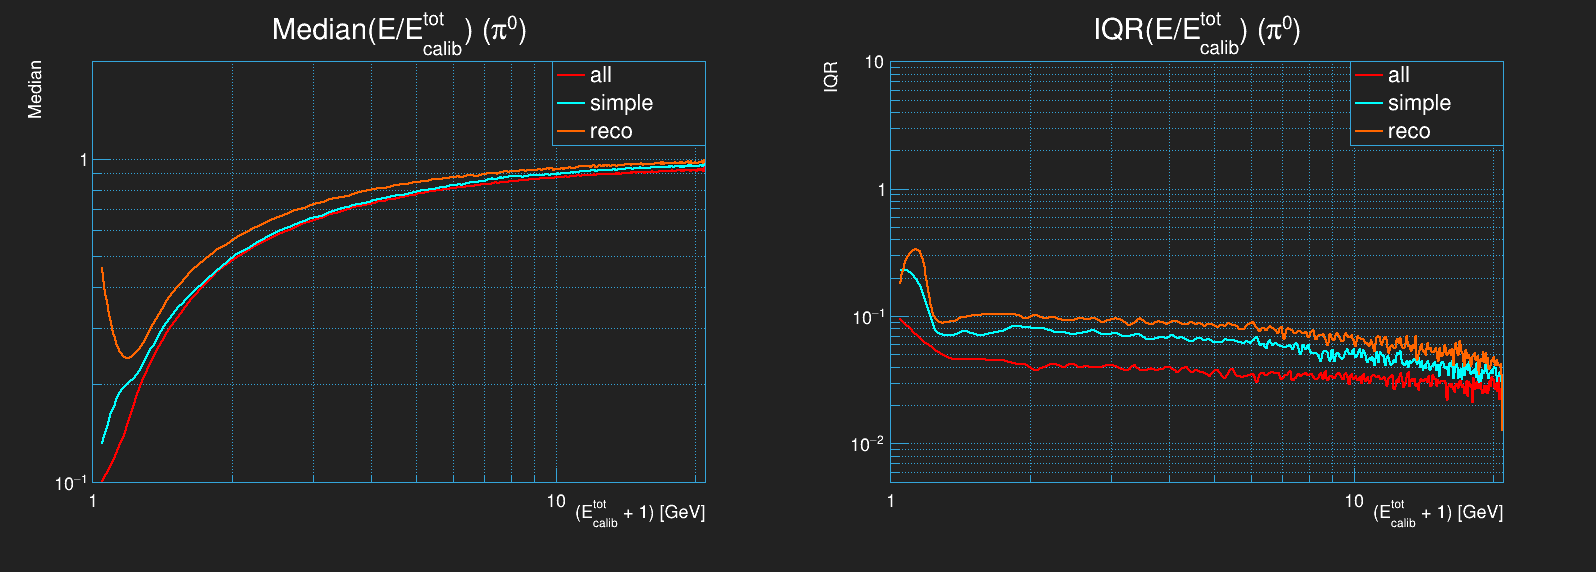

In [19]:
pion_conversions = {
    'pp':'#pi^{#pm}',
    'p0':'#pi^{0}',
}

c = {}
c_zoomed = {}

median_stack = {}
median_stack_zoomed = {}

iqr_stack = {}
iqr_stack_zoomed = {}

for key in iqr.keys():

    c[key] = rt.TCanvas(qu.RN(),qu.RN(),1600,600)
    median_stack[key] = rt.THStack(qu.RN(),qu.RN())
    iqr_stack[key] = rt.THStack(qu.RN(),qu.RN())
    c_zoomed[key] = rt.TCanvas(qu.RN(),qu.RN(),1600,600)
    median_stack_zoomed[key] = rt.THStack(qu.RN(),qu.RN())
    iqr_stack_zoomed[key] = rt.THStack(qu.RN(),qu.RN())

    for hist in median[key].values():        median_stack[key].Add(hist)
    for hist in median_zoomed[key].values(): median_stack_zoomed[key].Add(hist)
    for hist in iqr[key].values():        iqr_stack[key].Add(hist)
    for hist in iqr_zoomed[key].values(): iqr_stack_zoomed[key].Add(hist)
        
    c[key].Divide(2,1)
    
    c[key].cd(1)
    median_stack[key].Draw('NOSTACK C')
    rt.gPad.SetGrid()
    rt.gPad.SetBottomMargin(0.15)
    legend.Draw()
    
    c[key].cd(2)
    iqr_stack[key].Draw('NOSTACK C')
    rt.gPad.SetLogy()
    rt.gPad.SetGrid()
    rt.gPad.SetBottomMargin(0.15)
    legend.Draw()
    
    c_zoomed[key].Divide(2,1)
    
    c_zoomed[key].cd(1)
    median_stack_zoomed[key].Draw('NOSTACK C')
    rt.gPad.SetLogx()
    rt.gPad.SetLogy()
    rt.gPad.SetGrid()
    rt.gPad.SetBottomMargin(0.15)
    legend.Draw()
    
    c_zoomed[key].cd(2)
    iqr_stack_zoomed[key].Draw('NOSTACK C')
    rt.gPad.SetLogx()
    rt.gPad.SetLogy()
    rt.gPad.SetGrid()
    rt.gPad.SetBottomMargin(0.15)
    legend.Draw()

    median_stack[key].SetTitle('Median(E/E_{calib}^{tot}) ' +'({})'.format(pion_conversions[key]) + ';E_{calib}^{tot} [GeV];Median')
    median_stack_zoomed[key].SetTitle('Median(E/E_{calib}^{tot}) ' +'({})'.format(pion_conversions[key]) + ';(E_{calib}^{tot} + 1) [GeV];Median')
    iqr_stack[key].SetTitle('IQR(E/E_{calib}^{tot}) ' +'({})'.format(pion_conversions[key]) + ';E_{calib}^{tot} [GeV];IQR')
    iqr_stack_zoomed[key].SetTitle('IQR(E/E_{calib}^{tot}) ' +'({})'.format(pion_conversions[key]) + ';(E_{calib}^{tot} + 1) [GeV];IQR')
    
    for s in [iqr_stack[key], iqr_stack_zoomed[key]]:
        s.SetMinimum(5.0e-3)
        s.SetMaximum(1.0e1)

    for s in [median_stack[key]]:
        s.SetMinimum(0.8)
        s.SetMaximum(1.2)
        
    for s in [median_stack_zoomed[key]]:
        s.SetMinimum(1.0e-1)
        s.SetMaximum(2.0e0)
        
    c[key].Draw()
    c_zoomed[key].Draw()
    
    c[key].SaveAs('{}iqr_{}.png'.format(plotpath,key))
    c_zoomed[key].SaveAs('{}iqr_zoomed_{}.png'.format(plotpath,key))